<a href="https://colab.research.google.com/github/nicoletayy/fork_demo/blob/main/IS4226_MidTerm_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
from google.colab import drive
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def setup_environment():
    """Mount Google Drive and locate the Excel file with better debugging"""
    try:
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
        print("Google Drive mounted successfully!")

        base_path = '/content/drive/MyDrive/IS4226/Projects/'  # Fixed path to Projects (plural)
        file_name = 'MAN_stocks_data.xlsx'
        file_path = os.path.join(base_path, file_name)

        print(f"Looking for file at: {file_path}")

        if os.path.exists(file_path):
            print(f"✅ File found: {file_path}")
            return file_path
        else:
            print("❌ File not found at specified path.")
            print("Let me search for it in your Google Drive...")

            # Search for the file in the entire drive
            found_files = []
            for root, dirs, files in os.walk('/content/drive/MyDrive/'):
                if file_name in files:
                    found_path = os.path.join(root, file_name)
                    found_files.append(found_path)
                    print(f"✅ Found file at: {found_path}")

            if found_files:
                # Return the first found file
                return found_files[0]
            else:
                print("❌ Could not find the file anywhere in Google Drive.")
                return None

    except Exception as e:
        print(f"❌ Error during setup: {e}")
        return None

# Step 1: Load and explore the data
def load_stock_data(file_path):
    """Load all sheets from the Excel file into a dictionary of DataFrames"""
    if file_path is None:
        print("❌ No file path provided")
        return None

    try:
        print(f"📂 Loading file from: {file_path}")
        stocks_data = pd.read_excel(file_path, sheet_name=None)
        print("✅ File loaded successfully!")
        print("Available sheets:", list(stocks_data.keys()))

        # Print basic info about each sheet
        for sheet_name, df in stocks_data.items():
            print(f"\n{sheet_name} sheet preview:")
            print(df.head(3))
            print(f"Shape: {df.shape}")

        return stocks_data
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        return None

# FIXED: Properly handle the column structure
def clean_stock_data(df, ticker):
    try:
        print(f"   🔍 Debug: Original dataframe shape: {df.shape}")
        print(f"   🔍 Debug: First few rows of raw data:")
        print(df.head(5))

        df_clean = df.copy()

        if len(df_clean) > 2:
            # Set the column names from the first row
            df_clean.columns = df_clean.iloc[0]
            print(f"   🔍 Debug: Columns after setting from first row: {df_clean.columns.tolist()}")

            # Remove the first three rows (price types, ticker, and 'Date' row)
            df_clean = df_clean.iloc[3:].reset_index(drop=True)
            print(f"   🔍 Debug: After removing first 3 rows, shape: {df_clean.shape}")
            print(f"   🔍 Debug: First few rows after cleaning:")
            print(df_clean.head(3))

            # Check if 'Date' column exists
            if 'Date' not in df_clean.columns:
                print(f"   🔍 Debug: Available columns: {df_clean.columns.tolist()}")
                # Try to find the date column by name variations
                date_cols = [col for col in df_clean.columns if 'date' in str(col).lower() or 'time' in str(col).lower()]
                if date_cols:
                    print(f"   🔍 Debug: Found potential date columns: {date_cols}")
                    # Rename the first date-like column to 'Date'
                    df_clean = df_clean.rename(columns={date_cols[0]: 'Date'})
                else:
                    # If no date column found, check the first column
                    print(f"   🔍 Debug: No date column found, using first column: {df_clean.columns[0]}")
                    df_clean = df_clean.rename(columns={df_clean.columns[0]: 'Date'})

            print(f"   🔍 Debug: Final columns before processing: {df_clean.columns.tolist()}")

            # Convert date column
            df_clean['Date'] = pd.to_datetime(df_clean['Date'])

            # Convert numeric columns
            numeric_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
            for col in numeric_columns:
                if col in df_clean.columns:
                    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

            # Add ticker column if not present
            if 'Ticker' not in df_clean.columns:
                df_clean['Ticker'] = ticker

            df_clean = df_clean.sort_values('Date').reset_index(drop=True)

            print(f"✅ Successfully cleaned {ticker} data")
            print(f"   Shape: {df_clean.shape}")
            print(f"   Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
            print(f"   Final columns: {df_clean.columns.tolist()}")
            return df_clean
        else:
            print(f"❌ Not enough rows in {ticker} data")
            return None
    except Exception as e:
        print(f"❌ Error cleaning {ticker} data: {str(e)}")
        import traceback
        print(f"   🔍 Full error traceback:")
        traceback.print_exc()
        return None

def process_all_sheets(file_path):
    xl = pd.ExcelFile(file_path)
    sheet_names = xl.sheet_names
    print(f"📊 Found {len(sheet_names)} sheets: {sheet_names}")
    all_data = {}

    for sheet_name in sheet_names:
        print(f"\n🔧 Processing {sheet_name}...")

        try:
            df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
            cleaned_df = clean_stock_data(df, sheet_name)

            if cleaned_df is not None:
                all_data[sheet_name] = cleaned_df
            else:
                print(f"❌ Failed to process {sheet_name}")

        except Exception as e:
            print(f"❌ Error reading sheet {sheet_name}: {str(e)}")

    return all_data



In [58]:
def calculate_technical_indicators(df):
    """Calculate common technical indicators"""
    df = df.copy()

    print(f"   🔍 DEBUG: Starting calculate_technical_indicators")
    print(f"   🔍 DEBUG: Original columns: {df.columns.tolist()}")
    print(f"   🔍 DEBUG: DataFrame shape: {df.shape}")

    # The columns should be in this order after cleaning:
    # ['Date', 'META', 'META', 'META', 'META', 'META', 'META', 'Ticker']
    # These correspond to: Date, Adj Close, Close, High, Low, Open, Volume, Ticker

    print(f"   🔍 DEBUG: Column indices and their current names:")
    for i, col_name in enumerate(df.columns):
        print(f"   🔍 DEBUG:   Column {i}: '{col_name}'")

    # Create proper column names based on their positions
    proper_columns = ['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Ticker']

    print(f"   🔍 DEBUG: Renaming columns to: {proper_columns}")

    # Assign the proper column names directly
    df.columns = proper_columns

    print(f"   🔍 DEBUG: Columns after renaming: {df.columns.tolist()}")
    print(f"   🔍 DEBUG: First 3 rows after renaming:")
    print(df.head(3))

    # Use 'Adj Close' as the main price column
    price_column = 'Adj Close'

    if price_column not in df.columns:
        print(f"   ⚠️  {price_column} not found. Available columns: {df.columns.tolist()}")
        print(f"   🔍 DEBUG: Checking data types:")
        for col in df.columns:
            print(f"   🔍 DEBUG:   {col}: {df[col].dtype}, sample: {df[col].iloc[0] if len(df) > 0 else 'N/A'}")
        return df

    print(f"   🔍 DEBUG: Using '{price_column}' as price column")
    print(f"   🔍 DEBUG: Price column data type: {df[price_column].dtype}")
    print(f"   🔍 DEBUG: Price column sample values: {df[price_column].head(3).tolist()}")

    # Check if price column has numeric data
    if not pd.api.types.is_numeric_dtype(df[price_column]):
        print(f"   ⚠️  Price column '{price_column}' is not numeric. Converting...")
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')
        print(f"   🔍 DEBUG: After conversion - dtype: {df[price_column].dtype}, sample: {df[price_column].head(3).tolist()}")

    # Simple Moving Averages
    print(f"   🔍 DEBUG: Calculating SMA_20...")
    df['SMA_20'] = df[price_column].rolling(window=20).mean()
    print(f"   🔍 DEBUG: Calculating SMA_50...")
    df['SMA_50'] = df[price_column].rolling(window=50).mean()

    # Daily returns and volatility
    print(f"   🔍 DEBUG: Calculating Daily_Return...")
    df['Daily_Return'] = df[price_column].pct_change()
    df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()

    # RSI (Relative Strength Index)
    print(f"   🔍 DEBUG: Calculating RSI...")
    delta = df[price_column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    print(f"   🔍 DEBUG: Final columns after calculations: {df.columns.tolist()}")
    print(f"   🔍 DEBUG: Sample of calculated indicators:")
    print(f"   🔍 DEBUG:   SMA_20: {df['SMA_20'].iloc[-1] if pd.notna(df['SMA_20'].iloc[-1]) else 'N/A'}")
    print(f"   🔍 DEBUG:   SMA_50: {df['SMA_50'].iloc[-1] if pd.notna(df['SMA_50'].iloc[-1]) else 'N/A'}")
    print(f"   🔍 DEBUG:   RSI: {df['RSI'].iloc[-1] if pd.notna(df['RSI'].iloc[-1]) else 'N/A'}")

    print(f"   ✅ Technical indicators calculated using {price_column}")
    return df

In [59]:
def compare_stocks(cleaned_data):
    """Compare performance across different stocks"""
    comparison_data = []

    print(f"   🔍 DEBUG: Starting compare_stocks with {len(cleaned_data)} datasets")

    for ticker, df in cleaned_data.items():
        print(f"   🔍 DEBUG: Processing {ticker}...")
        print(f"   🔍 DEBUG:   Original columns: {df.columns.tolist()}")

        # We don't need to rename columns anymore since they were already renamed in calculate_technical_indicators
        df_mapped = df.copy()

        print(f"   🔍 DEBUG:   Using existing columns: {df_mapped.columns.tolist()}")

        # Use 'Adj Close' as the price column
        price_column = 'Adj Close'
        if price_column not in df_mapped.columns:
            print(f"   ❌ No price data found for {ticker}")
            print(f"   🔍 DEBUG:   Available columns: {df_mapped.columns.tolist()}")
            continue

        print(f"   🔍 DEBUG:   Price column found: {price_column}")
        print(f"   🔍 DEBUG:   Price data sample: {df_mapped[price_column].head(3).tolist()}")

        latest_price = df_mapped[price_column].iloc[-1]
        start_price = df_mapped[price_column].iloc[0]
        total_return = ((latest_price - start_price) / start_price) * 100
        avg_volume = df_mapped['Volume'].mean() if 'Volume' in df_mapped.columns else 0

        print(f"   🔍 DEBUG:   Start price: {start_price}, Latest price: {latest_price}, Return: {total_return:.2f}%")

        # Calculate volatility from daily returns
        volatility = df_mapped['Daily_Return'].std() * np.sqrt(252) if 'Daily_Return' in df_mapped.columns else 0

        # Calculate additional metrics
        high_column = 'High' if 'High' in df_mapped.columns else price_column
        low_column = 'Low' if 'Low' in df_mapped.columns else price_column
        max_price = df_mapped[high_column].max()
        min_price = df_mapped[low_column].min()
        current_rsi = df_mapped['RSI'].iloc[-1] if 'RSI' in df_mapped.columns and pd.notna(df_mapped['RSI'].iloc[-1]) else None

        comparison_data.append({
            'Ticker': ticker,
            'Start_Price': round(start_price, 2),
            'Current_Price': round(latest_price, 2),
            'Total_Return_%': round(total_return, 2),
            'Avg_Daily_Volume': int(avg_volume),
            'Annualized_Volatility_%': round(volatility * 100, 2),
            'All_Time_High': round(max_price, 2),
            'All_Time_Low': round(min_price, 2),
            'Current_RSI': round(current_rsi, 1) if current_rsi else 'N/A'
        })

    print(f"   🔍 DEBUG: Comparison data collected: {len(comparison_data)} stocks")
    return pd.DataFrame(comparison_data)

In [60]:
def create_visualizations(cleaned_data, comparison_df):
    """Create visualizations for stock analysis"""

    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Price comparison (normalized)
    for ticker, df in cleaned_data.items():
        # No need to map columns - they're already properly named
        df_mapped = df.copy()

        price_column = 'Adj Close'
        if price_column not in df_mapped.columns:
            continue

        normalized_price = (df_mapped[price_column] / df_mapped[price_column].iloc[0]) * 100
        axes[0, 0].plot(df_mapped.index, normalized_price, label=ticker, linewidth=2)

    axes[0, 0].set_title('Normalized Price Comparison\n(Base = 100)')
    axes[0, 0].set_ylabel('Normalized Price')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Plot 2: Daily returns distribution
    for ticker, df in cleaned_data.items():
        if 'Daily_Return' in df.columns:
            axes[0, 1].hist(df['Daily_Return'].dropna() * 100, alpha=0.6, label=ticker, bins=50)
    axes[0, 1].set_title('Distribution of Daily Returns')
    axes[0, 1].set_xlabel('Daily Return (%)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Total returns comparison
    colors = ['skyblue', 'lightcoral', 'lightgreen']
    if not comparison_df.empty:
        bars = axes[1, 0].bar(comparison_df['Ticker'], comparison_df['Total_Return_%'],
                             color=colors, alpha=0.7)
        axes[1, 0].set_title('Total Return Comparison')
        axes[1, 0].set_ylabel('Return (%)')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.1f}%', ha='center', va='bottom')

    # Plot 4: Volume comparison
    if not comparison_df.empty and 'Avg_Daily_Volume' in comparison_df.columns:
        axes[1, 1].bar(comparison_df['Ticker'], comparison_df['Avg_Daily_Volume'] / 1e6,
                      color=colors, alpha=0.7)
        axes[1, 1].set_title('Average Daily Volume')
        axes[1, 1].set_ylabel('Volume (Millions)')

    plt.tight_layout()
    plt.show()

    # Additional plot: Individual stock analysis
    for ticker, df in cleaned_data.items():
        # No need to map columns - they're already properly named
        df_mapped = df.copy()

        price_column = 'Adj Close'
        if price_column not in df_mapped.columns:
            continue

        fig, ax = plt.subplots(2, 1, figsize=(12, 8))

        # Price and moving averages
        ax[0].plot(df_mapped.index, df_mapped[price_column], label=price_column, linewidth=2, color='blue')
        if 'SMA_20' in df_mapped.columns:
            ax[0].plot(df_mapped.index, df_mapped['SMA_20'], label='20-day SMA', alpha=0.7, color='orange')
        if 'SMA_50' in df_mapped.columns:
            ax[0].plot(df_mapped.index, df_mapped['SMA_50'], label='50-day SMA', alpha=0.7, color='red')
        ax[0].set_title(f'{ticker} - Price and Moving Averages')
        ax[0].set_ylabel('Price ($)')
        ax[0].legend()
        ax[0].grid(True, alpha=0.3)

        # RSI
        if 'RSI' in df_mapped.columns:
            ax[1].plot(df_mapped.index, df_mapped['RSI'], label='RSI', color='purple', linewidth=2)
            ax[1].axhline(70, linestyle='--', alpha=0.7, color='red', label='Overbought (70)')
            ax[1].axhline(30, linestyle='--', alpha=0.7, color='green', label='Oversold (30)')
            ax[1].axhline(50, linestyle='--', alpha=0.3, color='gray', label='Neutral')
            ax[1].set_title(f'{ticker} - RSI Indicator')
            ax[1].set_ylabel('RSI')
            ax[1].set_ylim(0, 100)
            ax[1].legend()
            ax[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [61]:
def generate_analysis_report(cleaned_data, comparison_df):
    """Generate a comprehensive analysis report"""
    print("=" * 80)
    print("STOCK ANALYSIS REPORT")
    print("=" * 80)

    if comparison_df.empty:
        print("No data available for analysis")
        return

    # Overall comparison
    print("\nOVERALL PERFORMANCE COMPARISON:")
    print("-" * 80)
    # Format the comparison dataframe for better display
    display_df = comparison_df.copy()
    if 'Avg_Daily_Volume' in display_df.columns:
        display_df['Avg_Daily_Volume'] = (display_df['Avg_Daily_Volume'] / 1e6).round(2).astype(str) + 'M'
    print(display_df.to_string(index=False))

    # Find best and worst performers
    best_stock = comparison_df.loc[comparison_df['Total_Return_%'].idxmax()]
    worst_stock = comparison_df.loc[comparison_df['Total_Return_%'].idxmin()]

    print(f"\n🏆 BEST PERFORMER: {best_stock['Ticker']} ({best_stock['Total_Return_%']:.1f}%)")
    print(f"📉 WORST PERFORMER: {worst_stock['Ticker']} ({worst_stock['Total_Return_%']:.1f}%)")

    # Risk analysis
    if 'Annualized_Volatility_%' in comparison_df.columns:
        highest_vol = comparison_df.loc[comparison_df['Annualized_Volatility_%'].idxmax()]
        lowest_vol = comparison_df.loc[comparison_df['Annualized_Volatility_%'].idxmin()]
        print(f"📊 HIGHEST VOLATILITY: {highest_vol['Ticker']} ({highest_vol['Annualized_Volatility_%']:.1f}%)")
        print(f"📊 LOWEST VOLATILITY: {lowest_vol['Ticker']} ({lowest_vol['Annualized_Volatility_%']:.1f}%)")

    # Detailed analysis for each stock
    for ticker, df in cleaned_data.items():
        print(f"\n{'='*60}")
        print(f"DETAILED ANALYSIS: {ticker}")
        print(f"{'='*60}")

        # Basic statistics
        latest_data = df.iloc[-1]
        print(f"📅 Latest Date: {df['Date'].iloc[-1].strftime('%Y-%m-%d')}")

        price_column = 'Adj Close'
        if price_column not in df.columns:
            print(f"❌ Price data not available for {ticker}")
            continue

        print(f"💰 Current Price: ${latest_data[price_column]:.2f}")

        # Price performance
        start_price = df[price_column].iloc[0]
        current_price = df[price_column].iloc[-1]
        total_return = ((current_price - start_price) / start_price) * 100

        print(f"📈 Total Return: {total_return:.2f}%")
        print(f"📊 All Time High: ${df['High'].max():.2f}" if 'High' in df.columns else "")
        print(f"📊 All Time Low: ${df['Low'].min():.2f}" if 'Low' in df.columns else "")

        # Moving averages
        if 'SMA_20' in df.columns and pd.notna(latest_data['SMA_20']):
            print(f"📊 20-day SMA: ${latest_data['SMA_20']:.2f}")
            price_vs_sma20 = ((current_price - latest_data['SMA_20']) / latest_data['SMA_20']) * 100
            print(f"   Price vs SMA20: {price_vs_sma20:+.2f}%")

        if 'SMA_50' in df.columns and pd.notna(latest_data['SMA_50']):
            print(f"📊 50-day SMA: ${latest_data['SMA_50']:.2f}")
            price_vs_sma50 = ((current_price - latest_data['SMA_50']) / latest_data['SMA_50']) * 100
            print(f"   Price vs SMA50: {price_vs_sma50:+.2f}%")

        # RSI
        if 'RSI' in df.columns and pd.notna(latest_data['RSI']):
            print(f"📈 Current RSI: {latest_data['RSI']:.1f}")

        # Volume analysis
        if 'Volume' in df.columns:
            avg_volume = df['Volume'].mean()
            current_volume = latest_data['Volume'] if 'Volume' in latest_data else 0
            volume_ratio = (current_volume / avg_volume) if avg_volume > 0 else 0
            print(f"📊 Average Daily Volume: {avg_volume:,.0f}")
            print(f"📊 Current Volume vs Average: {volume_ratio:.2f}x")

        # Technical signals
        print(f"\n🎯 TECHNICAL SIGNALS:")

        # RSI signals
        if 'RSI' in df.columns and pd.notna(latest_data['RSI']):
            rsi = latest_data['RSI']
            if rsi > 70:
                print("  RSI Signal: 🔴 OVERBOUGHT (Potential sell signal)")
            elif rsi < 30:
                print("  RSI Signal: 🟢 OVERSOLD (Potential buy signal)")
            else:
                print("  RSI Signal: ⚪ NEUTRAL")
        else:
            print("  RSI Signal: 📊 Not available")

        # Moving average signals
        if ('SMA_20' in df.columns and 'SMA_50' in df.columns and
            pd.notna(latest_data['SMA_20']) and pd.notna(latest_data['SMA_50'])):
            if latest_data['SMA_20'] > latest_data['SMA_50']:
                print("  Moving Average: 🟢 BULLISH (20-day above 50-day)")
            else:
                print("  Moving Average: 🔴 BEARISH (20-day below 50-day)")

        # Price position relative to moving averages
        if 'SMA_20' in df.columns and pd.notna(latest_data['SMA_20']):
            if current_price > latest_data['SMA_20']:
                print("  Price Position: 🟢 Above 20-day SMA")
            else:
                print("  Price Position: 🔴 Below 20-day SMA")

        # Volatility analysis
        if 'Volatility_20' in df.columns and pd.notna(latest_data['Volatility_20']):
            volatility_pct = latest_data['Volatility_20'] * 100
            print(f"  Recent Volatility: {volatility_pct:.2f}%")

        # Recommendation based on signals
        print(f"\n💡 INVESTMENT INSIGHTS for {ticker}:")

        bullish_signals = 0
        bearish_signals = 0

        # Count signals
        if 'RSI' in df.columns and pd.notna(latest_data['RSI']):
            if latest_data['RSI'] < 30:
                bullish_signals += 1
            elif latest_data['RSI'] > 70:
                bearish_signals += 1

        if ('SMA_20' in df.columns and 'SMA_50' in df.columns and
            pd.notna(latest_data['SMA_20']) and pd.notna(latest_data['SMA_50'])):
            if latest_data['SMA_20'] > latest_data['SMA_50']:
                bullish_signals += 1
            else:
                bearish_signals += 1

        if 'SMA_20' in df.columns and pd.notna(latest_data['SMA_20']):
            if current_price > latest_data['SMA_20']:
                bullish_signals += 1
            else:
                bearish_signals += 1

        # Generate recommendation
        if bullish_signals > bearish_signals:
            print("  Overall Sentiment: 🟢 BULLISH")
            if total_return > 0:
                print("  Recommendation: Consider holding or adding to position")
            else:
                print("  Recommendation: Potential buying opportunity")
        elif bearish_signals > bullish_signals:
            print("  Overall Sentiment: 🔴 BEARISH")
            if total_return > 0:
                print("  Recommendation: Consider taking profits")
            else:
                print("  Recommendation: Exercise caution, consider waiting")
        else:
            print("  Overall Sentiment: ⚪ NEUTRAL")
            print("  Recommendation: Monitor for clearer signals")

    # Market summary
    print(f"\n{'='*80}")
    print("MARKET SUMMARY")
    print(f"{'='*80}")

    avg_return = comparison_df['Total_Return_%'].mean()
    best_return = comparison_df['Total_Return_%'].max()
    worst_return = comparison_df['Total_Return_%'].min()

    print(f"📈 Average Return Across All Stocks: {avg_return:.2f}%")
    print(f"🚀 Best Performing Stock: {best_stock['Ticker']} ({best_return:.2f}%)")
    print(f"📉 Worst Performing Stock: {worst_stock['Ticker']} ({worst_return:.2f}%)")

    # Count bullish vs bearish stocks
    bullish_count = 0
    for ticker, df in cleaned_data.items():
        if 'RSI' in df.columns and 'SMA_20' in df.columns:
            latest = df.iloc[-1]
            bullish_signals = 0
            if pd.notna(latest['RSI']) and latest['RSI'] < 50:
                bullish_signals += 1
            if 'SMA_20' in df.columns and 'SMA_50' in df.columns:
                if pd.notna(latest['SMA_20']) and pd.notna(latest['SMA_50']):
                    if latest['SMA_20'] > latest['SMA_50']:
                        bullish_signals += 1
            if bullish_signals >= 1:
                bullish_count += 1

    bearish_count = len(cleaned_data) - bullish_count

    print(f"📊 Market Sentiment: {bullish_count}/{len(cleaned_data)} stocks show bullish tendencies")
    print(f"📊 {bearish_count}/{len(cleaned_data)} stocks show bearish tendencies")

    print(f"\n📋 REPORT GENERATED ON: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")

STOCK DATA ANALYSIS TOOL

Step 1: Setting up environment and locating file...
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!
Looking for file at: /content/drive/MyDrive/IS4226/Projects/MAN_stocks_data.xlsx
✅ File found: /content/drive/MyDrive/IS4226/Projects/MAN_stocks_data.xlsx

Step 2: Loading stock data...
📂 Loading file from: /content/drive/MyDrive/IS4226/Projects/MAN_stocks_data.xlsx
✅ File loaded successfully!
Available sheets: ['META', 'AAPL', 'NFLX']

META sheet preview:
                 Price   Adj Close       Close        High         Low  \
0               Ticker        META        META        META        META   
1                 Date         NaN         NaN         NaN         NaN   
2  2024-08-28 00:00:00  515.016541  516.780029  521.090027  512.450012   

         Open   Volume  
0        META     META  
1         NaN      NaN  
2 

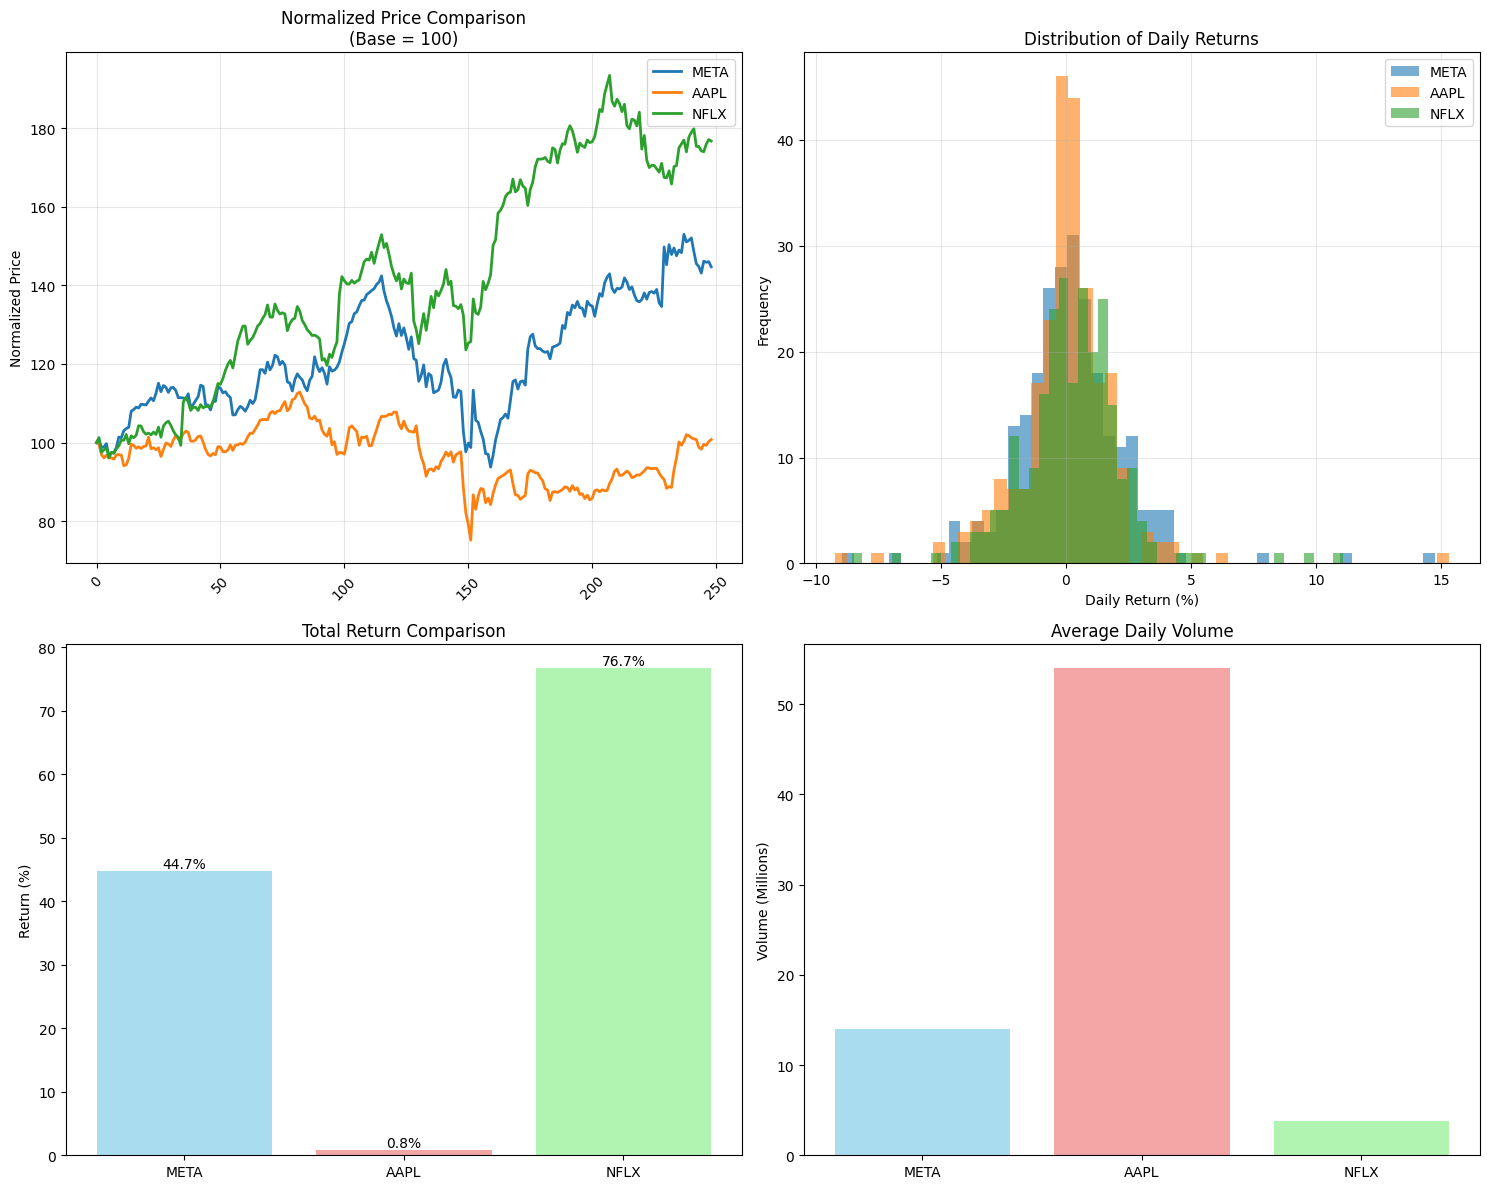

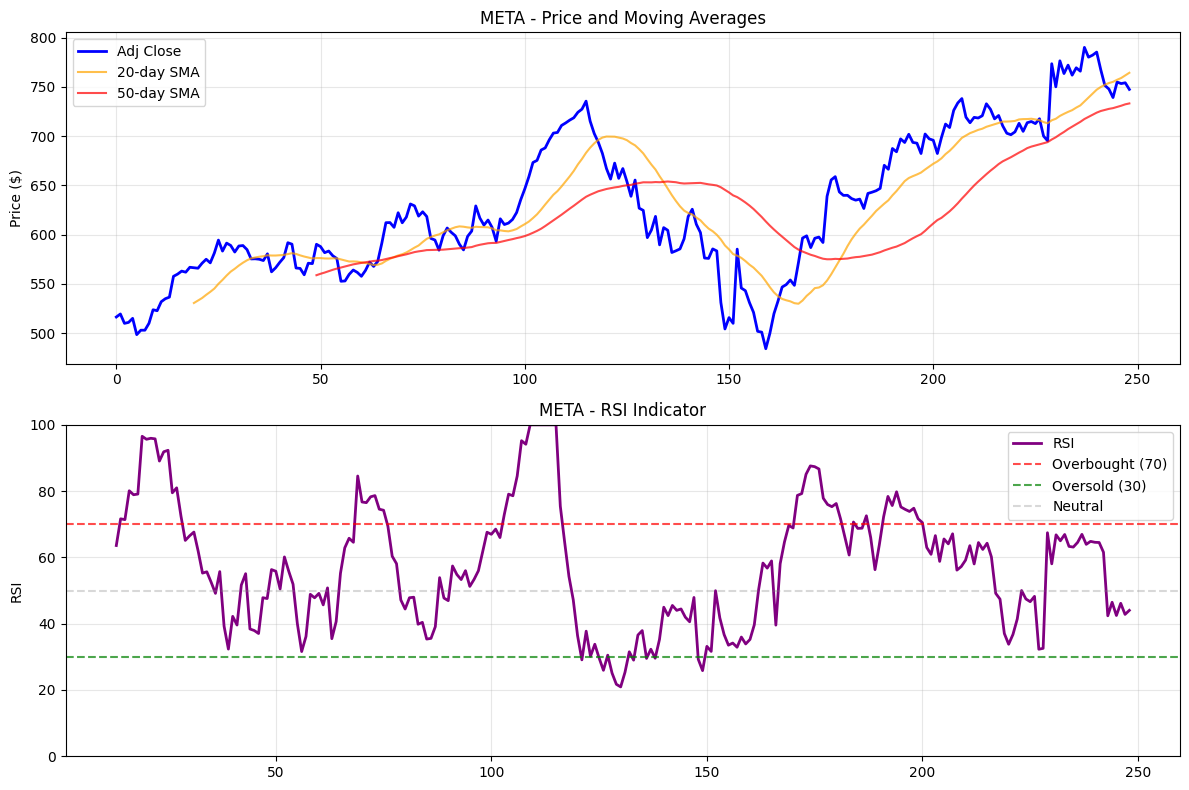

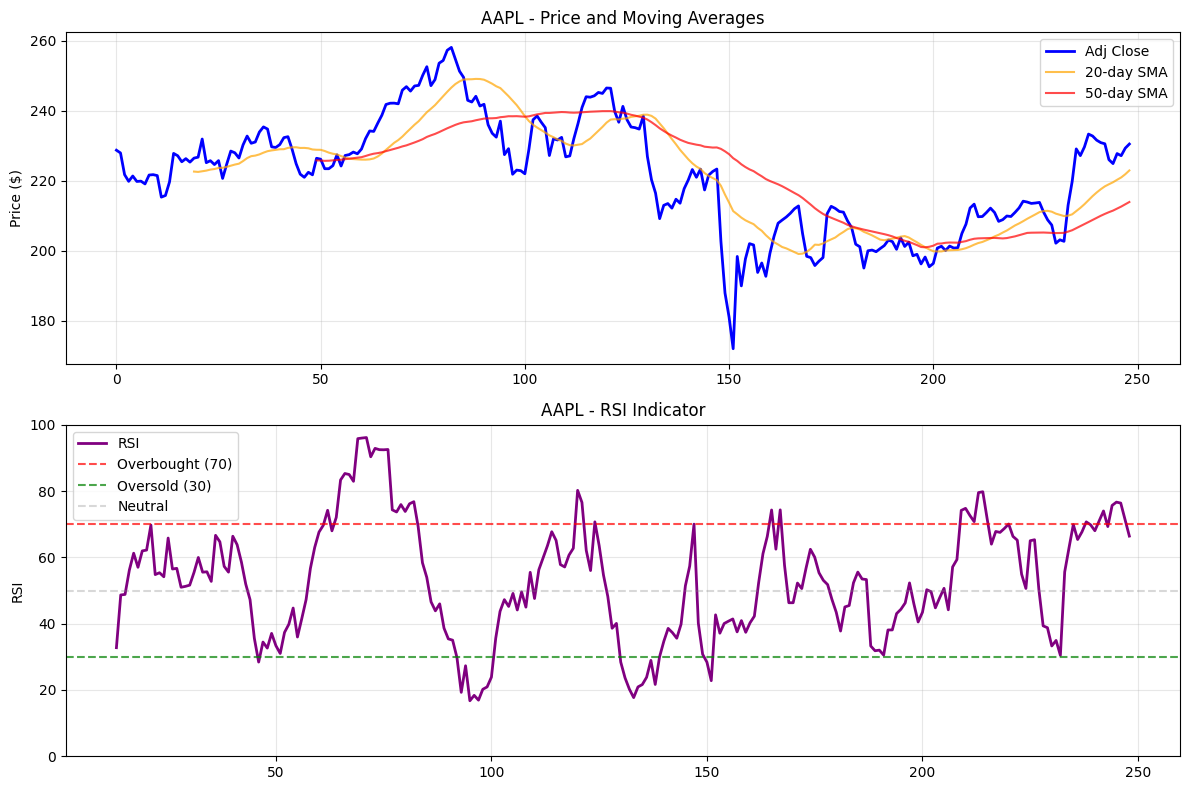

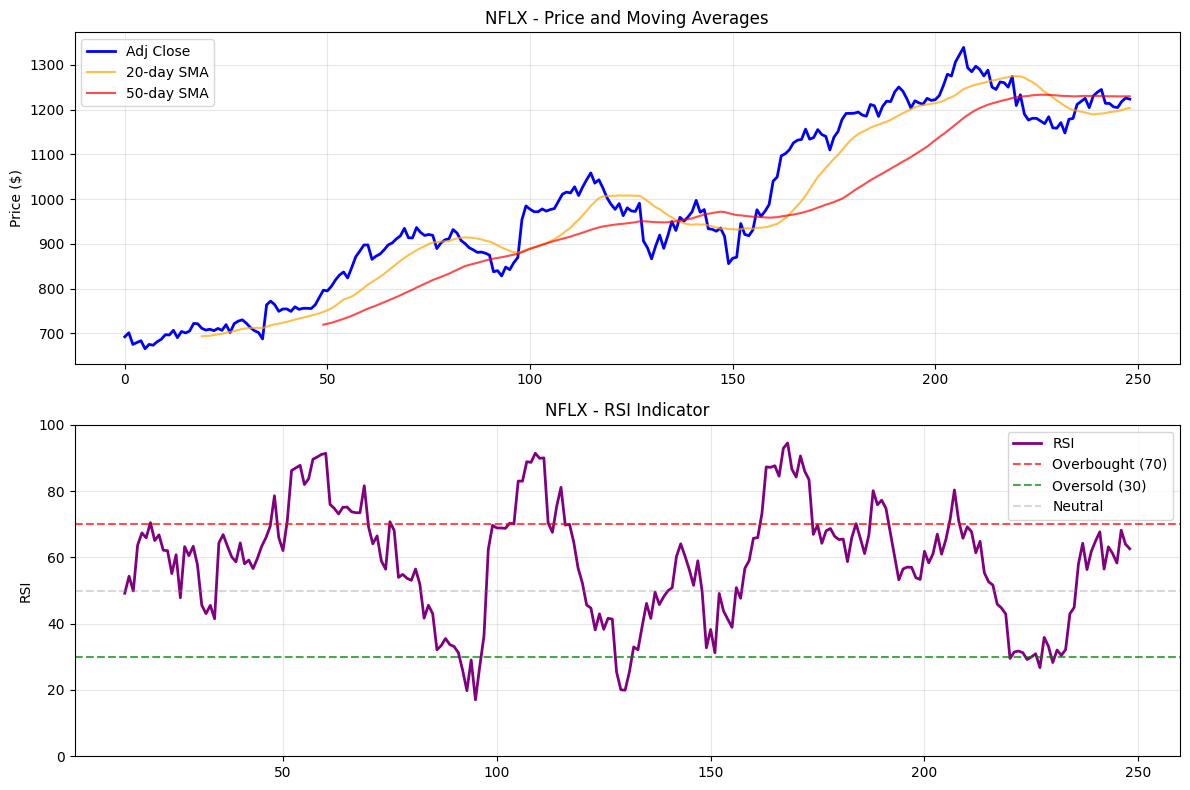


Step 7: Generating analysis report...
STOCK ANALYSIS REPORT

OVERALL PERFORMANCE COMPARISON:
--------------------------------------------------------------------------------
Ticker  Start_Price  Current_Price  Total_Return_% Avg_Daily_Volume  Annualized_Volatility_%  All_Time_High  All_Time_Low  Current_RSI
  META       516.45         747.38           44.71           14.02M                    36.83         796.25        479.80         44.0
  AAPL       228.73         230.49            0.77           53.97M                    32.25         260.10        169.21         66.4
  NFLX       692.48        1223.50           76.68            3.75M                    33.18        1341.15        660.80         62.6

🏆 BEST PERFORMER: NFLX (76.7%)
📉 WORST PERFORMER: AAPL (0.8%)
📊 HIGHEST VOLATILITY: META (36.8%)
📊 LOWEST VOLATILITY: AAPL (32.2%)

DETAILED ANALYSIS: META
📅 Latest Date: 2025-08-27
💰 Current Price: $747.38
📈 Total Return: 44.71%
📊 All Time High: $796.25
📊 All Time Low: $479.80
📊 20-

In [62]:
# Main execution function
def main():
    """Main function to run the complete analysis"""
    try:
        print("=" * 60)
        print("STOCK DATA ANALYSIS TOOL")
        print("=" * 60)

        print("\nStep 1: Setting up environment and locating file...")
        file_path = setup_environment()

        if file_path is None:
            print("\n❌ Could not find the file.")
            return

        print("\nStep 2: Loading stock data...")
        stocks_data = load_stock_data(file_path)

        if stocks_data is None:
            print("❌ Failed to load data. Exiting.")
            return

        print("\nStep 3: Cleaning and preprocessing data...")
        cleaned_data = {}
        for sheet_name, df in stocks_data.items():
            ticker = sheet_name
            print(f"📊 Processing {ticker}...")
            cleaned_df = clean_stock_data(df, ticker)
            if cleaned_df is not None:
                cleaned_data[ticker] = cleaned_df
                print(f"   ✅ {ticker} data shape: {cleaned_df.shape}")
                print(f"   📅 Date range: {cleaned_df['Date'].min()} to {cleaned_df['Date'].max()}")
            else:
                print(f"   ❌ Failed to clean {ticker} data")

        if not cleaned_data:
            print("❌ No data was successfully cleaned. Exiting.")
            return

        print("\nStep 4: Calculating technical indicators...")
        for ticker in cleaned_data:
            print(f"   Calculating indicators for {ticker}...")
            cleaned_data[ticker] = calculate_technical_indicators(cleaned_data[ticker])
            print(f"   ✅ Technical indicators calculated for {ticker}")

        print("\nStep 5: Performing comparative analysis...")
        comparison_df = compare_stocks(cleaned_data)
        if not comparison_df.empty:
            print("\n📈 Stock Performance Comparison:")
            print(comparison_df.round(2).to_string(index=False))
        else:
            print("❌ No data available for comparison")

        print("\nStep 6: Creating visualizations...")
        create_visualizations(cleaned_data, comparison_df)

        print("\nStep 7: Generating analysis report...")
        generate_analysis_report(cleaned_data, comparison_df)

        # Final summary
        print("\n" + "="*60)
        print("ANALYSIS COMPLETE 🎉")
        print("="*60)
        print(f"Analyzed {len(cleaned_data)} stocks:")
        for ticker in cleaned_data.keys():
            print(f"  ✅ {ticker}")

    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        import traceback
        traceback.print_exc()

# Run the analysis
if __name__ == "__main__":
    main()